In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

SEED = 42

In [2]:
projects = pd.read_csv("../data/nrao_projects.csv")
projects = projects.set_index('project_code')

In [3]:
projects = projects.query('fs_type == "line"')
projects.shape

(3628, 12)

In [4]:
measurements = pd.read_csv('../../nrao_measurements.csv')
measurements = measurements.set_index('project_code')
measurements = measurements[measurements.fs_type == 'line']

/var/folders/vx/9pb2fpkj3m5bkbwxzyx6sz5m0000gn/T/ipykernel_5569/229205413.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  measurements = pd.read_csv('../../nrao_measurements.csv')


## Remove outliers from projects and measurements

See 'Identifying_High_Measurement_Projects.ipynb' in 'data' folder

From this notebook, any project with > 26.5 measurements is an outlier

In [5]:
project_measurements = measurements.groupby(measurements.index)\
    .project_title.count()\
        .sort_values(ascending=False)\
        .to_frame()
project_measurements.columns = ['measurement_count']
project_measurements.head()

,measurement_count
project_code,
2017.1.00161.L,289
2017.1.00886.L,283
2021.2.00052.S,265
2023.1.00963.S,253
2022.1.00224.S,188


In [6]:
outliers = project_measurements[project_measurements.measurement_count > 26.5]

In [7]:
measurements = measurements.loc[~measurements.index.isin(outliers.index)]
projects = projects.loc[~projects.index.isin(outliers.index)]

### Remove measurements that have incorrectly formatted `band`

In [8]:
measurements['band'] = pd.to_numeric(measurements['band'], errors='coerce', downcast='integer')
valid_band_values = set(range(1, 11))
measurements = measurements[measurements['band'].isin(valid_band_values)] # Removing any rows with incorrect band formatting

### Make sure projects dataframe matches projects in measurement dataframes after drops

In [9]:
projects = projects.loc[measurements.index.unique()]

## Train-test split

In [10]:
train_texts, test_texts = train_test_split(projects.lemmatized_no_sw_text, random_state=SEED)

In [11]:
print(f'Number of train texts:{len(list(train_texts))}')
print(f'Number of test texts:{len(list(test_texts))}')

Number of train texts:2462
Number of test texts:821


In [12]:
train_texts

project_code
2022.1.01108.S    probe kinematics streamer understand star form...
2021.1.01495.S    revolutionary insight z gas dust physic althou...
2021.1.00055.S    comprehensive ism view pc scale sub l galaxy z...
2021.2.00056.S    panta rei mass energy flow parsec sub parsec s...
2018.A.00068.T    accretion burst event high mass yso g episodic...
                                        ...                        
2016.1.00615.S    probe dense gas physic extreme southern molecu...
2016.1.00744.S    investigate water deuteration young protostell...
2016.1.01344.S    multi wavelength image possibly planet induced...
2015.1.01235.S    core mass function far outer galaxy cloud dist...
2023.1.00367.S    conic cosmic noon ism condition survey cosmic ...
Name: lemmatized_no_sw_text, Length: 2462, dtype: object

### LDA class

In [13]:
class LDA_Model:
    def __init__(self, N_topics=3):
        self.N_topics = N_topics
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.lda = LatentDirichletAllocation(n_components=self.N_topics, random_state=SEED)
    
    def fit(self, corpus):
        termFrequency = self.countVectorizer.fit_transform(corpus)
        self.lda.fit(termFrequency)
        return self.lda.transform(termFrequency)

    # Additional method to transform new data
    def transform(self, corpus):
        termFrequency = self.countVectorizer.transform(corpus)
        return self.lda.transform(termFrequency)

#### Initialize Model

In [14]:
lda_model = LDA_Model(N_topics=50)

#### Fit model on training set

In [15]:
train_topics = lda_model.fit(train_texts)

In [16]:
words = lda_model.countVectorizer.get_feature_names_out()

In [17]:
N = 10 #number of top words to show
topic_components = lda_model.lda.components_

for topic_idx, topic in enumerate(topic_components):
    print(f"Topic {topic_idx}:")
    # Get the indices of the top N words for this topic
    top_word_indices = topic.argsort()[-N:][::-1]
    # Print these words with their weights
    for word_idx in top_word_indices:
        print(f"{words[word_idx]} (weight: {topic[word_idx]:.2f})")
    print("\n")

Topic 0:
strip (weight: 50.65)
tail (weight: 43.06)
pressure (weight: 41.53)
gas (weight: 31.74)
ram (weight: 30.99)
molecular (weight: 23.63)
dense (weight: 23.21)
physical (weight: 14.94)
region (weight: 14.66)
nucleus (weight: 14.15)


Topic 1:
outflow (weight: 882.61)
jet (weight: 378.11)
wind (weight: 211.61)
disk (weight: 206.87)
high (weight: 196.17)
star (weight: 163.81)
molecular (weight: 158.93)
observation (weight: 152.68)
velocity (weight: 140.84)
scale (weight: 130.84)


Topic 2:
gas (weight: 351.46)
molecular (weight: 279.12)
galaxy (weight: 249.32)
cloud (weight: 147.67)
tracer (weight: 136.49)
dense (weight: 129.51)
study (weight: 114.30)
observation (weight: 107.05)
spiral (weight: 105.43)
star (weight: 101.85)


Topic 3:
molecular (weight: 91.55)
gas (weight: 61.83)
diffuse (weight: 49.20)
observation (weight: 40.88)
line (weight: 40.60)
ice (weight: 34.51)
propose (weight: 34.48)
absorption (weight: 31.04)
allow (weight: 30.79)
chemistry (weight: 28.31)


Topic 4:
di

In [18]:
train_doc_topic = pd.DataFrame(train_topics)
train_doc_topic = train_doc_topic.set_index(train_texts.index.values)
train_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2022.1.01108.S,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.151758,0.000235,0.346698,0.000235,...,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235
2021.1.01495.S,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,...,0.000171,0.000171,0.150745,0.000171,0.000171,0.219299,0.000171,0.000171,0.000171,0.000171
2021.1.00055.S,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.204172,...,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161
2021.2.00056.S,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,...,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194
2018.A.00068.T,0.000175,0.059577,0.000175,0.000175,0.000175,0.128074,0.200258,0.000175,0.000175,0.000175,...,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.145325


In [19]:
train_texts = pd.DataFrame(train_texts)

### Match test data into topics

In [20]:
test_topics = lda_model.transform(test_texts)

In [21]:
test_doc_topic= pd.DataFrame(test_topics.tolist())
test_doc_topic= test_doc_topic.set_index(test_texts.index.values)
test_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2017.1.01260.S,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,...,0.000217,0.000217,0.000217,0.000217,0.139139,0.517560,0.000217,0.000217,0.000217,0.000217
2016.1.01372.S,0.000256,0.000256,0.029661,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,...,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256
2019.1.01398.S,0.000202,0.115943,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,...,0.000202,0.000202,0.000202,0.000202,0.063503,0.707017,0.000202,0.000202,0.000202,0.000202
2017.1.01230.S,0.000222,0.000222,0.000222,0.000222,0.000222,0.000222,0.000222,0.000222,0.000222,0.137161,...,0.000222,0.000222,0.000222,0.000222,0.000222,0.348337,0.000222,0.000222,0.000222,0.000222
2021.1.00045.S,0.000171,0.000171,0.000171,0.000171,0.000171,0.058735,0.000171,0.000171,0.000171,0.000171,...,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.293903


In [22]:
test_texts = pd.DataFrame(test_texts)

### Group documents to highest matching topic

Combine project topic vector frames

In [23]:
proj_topics = pd.concat([train_doc_topic, test_doc_topic])
proj_topics

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2022.1.01108.S,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.151758,0.000235,0.346698,0.000235,...,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235
2021.1.01495.S,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,...,0.000171,0.000171,0.150745,0.000171,0.000171,0.219299,0.000171,0.000171,0.000171,0.000171
2021.1.00055.S,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.204172,...,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161
2021.2.00056.S,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,...,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194
2018.A.00068.T,0.000175,0.059577,0.000175,0.000175,0.000175,0.128074,0.200258,0.000175,0.000175,0.000175,...,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.145325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019.1.01461.S,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.030220,0.000182,...,0.000182,0.000182,0.000182,0.000182,0.000182,0.077800,0.000182,0.000182,0.000182,0.000182
2023.1.01206.S,0.000183,0.000183,0.000183,0.000183,0.015246,0.000183,0.000183,0.000183,0.000183,0.268889,...,0.090452,0.000183,0.000183,0.000183,0.000183,0.302937,0.000183,0.000183,0.000183,0.000183
2021.1.00726.S,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,...,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190
2017.1.00261.S,0.000175,0.153244,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.076936,...,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.083825,0.000175


Take highest matching topic for each project

In [24]:
proj_topics['max_topic'] = proj_topics.apply(lambda x: x.argmax(), axis=1)

Create data frame with project id and max topic

In [25]:
proj_max_topic = proj_topics['max_topic'].to_frame()
proj_max_topic

,max_topic
2022.1.01108.S,8
2021.1.01495.S,21
2021.1.00055.S,21
2021.2.00056.S,23
2018.A.00068.T,20
...,...
2019.1.01461.S,21
2023.1.01206.S,45
2021.1.00726.S,21
2017.1.00261.S,12


### Add `max_topic` to `measurements` frame to be able to group measurements by max topic

In [26]:
measurements = pd.merge(measurements, proj_max_topic, left_index=True, right_index=True)

In [27]:
proj_max_topic.value_counts().describe()

count     50.000000
mean      65.660000
std       87.445986
min        4.000000
25%       14.500000
50%       28.500000
75%       87.250000
max      419.000000
Name: count, dtype: float64

There are a few topics that match to a large number of documents. Perhaps we need a better topic model or to group documents by project_topic vector similarity.

Eyeball comparison of documents by max topic. This requires looking at the online explorer since printing out abstracts in here gets messy.

In [28]:
proj_max_topic[proj_max_topic.max_topic == 3].head()

,max_topic
2019.1.00799.S,3
2023.1.01573.S,3
2019.A.00023.S,3
2017.1.00575.S,3
2013.1.01194.S,3


### Generate test projects measurements
This will be useful for calculating hit rates to evaluate model performance.

**NOTE!!!**
You should not sort these, however tempting. We need to preserve the relationships of the entries to not lose measurement information.

In [29]:
test_proj_meas = measurements.loc[test_texts.index]
test_proj_meas = test_proj_meas.groupby(test_proj_meas.index)\
    .agg({
        'low_freq': lambda x: round(x, 4).tolist(),
        'high_freq': lambda x: round(x, 4).tolist(),
        'med_freq': lambda x: round(x, 4).tolist(),
        'diff_freq': lambda x: round(x, 4).tolist()
    })
test_proj_meas.head()

,low_freq,high_freq,med_freq,diff_freq
project_code,,,,
2011.0.00010.S,"[90.38, 90.7, 91.69, 92.89, 217.59, 218.67, 21...","[90.62, 90.93, 91.92, 93.12, 218.53, 219.6, 21...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9..."
2011.0.00121.S,"[319.07, 320.48, 319.83, 319.36, 319.71, 316.59]","[320.94, 322.35, 321.71, 321.24, 321.58, 318.47]","[320.005, 321.415, 320.77, 320.3, 320.645, 317...","[1.87, 1.87, 1.88, 1.88, 1.87, 1.88]"
2011.0.00133.S,"[330.24, 332.19, 342.24, 344.24]","[332.12, 334.07, 344.12, 346.12]","[331.18, 333.13, 343.18, 345.18]","[1.88, 1.88, 1.88, 1.88]"
2011.0.00191.S,"[343.04, 344.91, 355.04, 356.91, 343.08, 344.9...","[344.91, 346.79, 356.91, 358.79, 344.96, 346.8...","[343.975, 345.85, 355.975, 357.85, 344.02, 345...","[1.87, 1.88, 1.87, 1.88, 1.88, 1.89, 1.88, 1.89]"
2011.0.00210.S,"[219.42, 219.81, 230.4, 231.18, 219.44, 219.82...","[219.66, 220.05, 230.64, 231.42, 219.67, 220.0...","[219.54, 219.93, 230.52, 231.3, 219.555, 219.9...","[0.24, 0.24, 0.24, 0.24, 0.23, 0.24, 0.24, 0.23]"


### Generate train topic measurements
We will use these to engineer 'areas of interest' among topics using DBSCAN

**NOTE!!!**
You should not sort these, however tempting. We need to preserve the relationships of the entries to not lose measurement information.

In [30]:
train_topic_freqs = measurements.loc[train_texts.index]\
    .groupby('max_topic')\
    .agg({
        'low_freq': lambda x: round(x, 4).tolist(),
        'high_freq': lambda x: round(x, 4).tolist(),
        'med_freq': lambda x: round(x, 4).tolist(),
        'diff_freq': lambda x: round(x, 4).tolist(),
        'band': lambda x: x.astype('int64').tolist()
    })
train_topic_freqs

,low_freq,high_freq,med_freq,diff_freq,band
max_topic,,,,,
0,"[212.19, 214.19, 226.19, 228.19, 225.52, 239.6...","[214.06, 216.06, 228.06, 230.06, 227.52, 241.6...","[213.125, 215.125, 227.125, 229.125, 226.52, 2...","[1.87, 1.87, 1.87, 1.87, 2.0, 2.0, 1.87, 1.87,...","[6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, ..."
1,"[477.19, 478.99, 489.19, 491.14, 477.18, 489.1...","[479.19, 480.99, 491.19, 493.14, 479.18, 491.1...","[478.19, 479.99, 490.19, 492.14, 478.18, 490.1...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
2,"[100.22, 101.72, 112.46, 114.71, 95.72, 96.97,...","[102.1, 103.6, 114.33, 115.64, 97.6, 98.84, 10...","[101.16, 102.66, 113.395, 115.175, 96.66, 97.9...","[1.88, 1.88, 1.87, 0.93, 1.88, 1.87, 1.87, 1.8...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, ..."
3,"[186.31, 186.35, 186.61, 187.56, 187.86, 198.7...","[186.37, 186.4, 186.67, 187.61, 189.74, 198.78...","[186.34, 186.375, 186.64, 187.585, 188.8, 198....","[0.06, 0.05, 0.06, 0.05, 1.88, 0.06, 0.06, 0.0...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, ..."
4,"[330.56, 345.76, 330.55, 219.53, 220.37, 230.5...","[330.61, 345.82, 330.61, 219.59, 220.43, 230.5...","[330.585, 345.79, 330.58, 219.56, 220.4, 230.5...","[0.05, 0.06, 0.06, 0.06, 0.06, 0.05, 0.06, 0.1...","[7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
5,"[94.56, 95.14, 107.67, 109.86, 216.09, 218.09,...","[96.43, 95.19, 109.54, 110.33, 217.96, 219.96,...","[95.495, 95.165, 108.605, 110.095, 217.025, 21...","[1.87, 0.05, 1.87, 0.47, 1.87, 1.87, 1.87, 1.8...","[3, 3, 3, 3, 6, 6, 6, 6, 3, 3, 3, 3, 7, 7, 7, ..."
6,"[343.33, 345.14, 114.66, 283.67, 285.55, 308.2...","[345.21, 347.01, 115.59, 285.54, 287.41, 310.1...","[344.27, 346.075, 115.125, 284.605, 286.48, 30...","[1.88, 1.87, 0.93, 1.87, 1.86, 1.86, 1.87, 1.8...","[7, 7, 3, 7, 7, 7, 7, 6, 6, 3, 3, 3, 6, 6, 6, ..."
7,"[95.81, 95.87, 95.92, 96.71, 98.47, 98.56, 107...","[95.86, 95.93, 95.98, 96.77, 98.53, 98.62, 109...","[95.835, 95.9, 95.95, 96.74, 98.5, 98.59, 108....","[0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 1.87, 0.0...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
8,"[219.52, 219.91, 220.36, 230.5, 232.0, 219.52,...","[219.58, 219.97, 220.42, 230.56, 234.0, 219.59...","[219.55, 219.94, 220.39, 230.53, 233.0, 219.55...","[0.06, 0.06, 0.06, 0.06, 2.0, 0.07, 0.07, 0.07...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, ..."


### Use KNN to find $\epsilon$ for DBSCAN
The DBSCAN papers suggest using the elbow method with $k=2*\text{num dimensions}-1$ to find the optimal $\epsilon$

In our case since we're only using 1 dimension we use $k=2$

### Try mining a topic by hand

In [45]:
inspect_topic = 1

In [46]:
X = np.array(train_topic_freqs.loc[inspect_topic].med_freq)
X = X.reshape(-1, 1)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

In [47]:
eps = [0.78,
       0.53,
       0.53,
       1.87,
       3.515,
       0.81,
       0.97,
       1.105,
       17,
       2.41,
       0.865,
       2,
       2.05,
       0.6,
       2.05,
       2.185,
       1.965,
       1.875,
       3.445,
       0.76,
       2.19,
       2.055,
       2.105,
       2.225,
       3.73,
       2,
       1.5,
       0.75,
       0.84,
       2.69,
       0.69,
       2.025,
       0.225,
       1.47,
       0.9,
       0.93,
       3,
       1.89,
       0.71,
       2,
       1.165,
       1.87,
       0.72,
       2.23,
       1.085,
       0.62,
       1.875,
       1.15,
       0.575,
       1.855
       ]


In [48]:
params_frame = pd.DataFrame(eps)
params_frame.index.name = 'topic'
params_frame.columns = ['eps']
params_frame

,eps
topic,
0,0.780
1,0.530
2,0.530
3,1.870
4,3.515
5,0.810
6,0.970
7,1.105
8,17.000


In [49]:
# db = DBSCAN(eps=0.25, min_samples=2).fit(list(zip(train_topic_freqs.loc[inspect_topic].med_freq)))
db = HDBSCAN(max_cluster_size=200, min_cluster_size=5).fit(list(zip(train_topic_freqs.loc[inspect_topic].med_freq)))

In [50]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_points = len(list(labels))
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Total number of measurements: %d" % n_points)
print("Estimated number of noise measurements: %d" % n_noise)
print(f"Noise percentage: {round(list(labels).count(-1)/labels.shape[0], 3)}")
print(f'Signal to noise ratio: {1-round(list(labels).count(-1)/labels.shape[0], 3)}')

Estimated number of clusters: 76
Total number of measurements: 920
Estimated number of noise measurements: 164
Noise percentage: 0.178
Signal to noise ratio: 0.8220000000000001


In [51]:
import matplotlib.pyplot as plt
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        alpha=0.5
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
        alpha=0.5
    )

plt.title(f"Number of engineered frequency median clusters: {n_clusters}")
plt.ylabel('Frequency Median')
plt.suptitle(f"Frequencies mined for topic {inspect_topic}")
plt.show()

AttributeError: 'HDBSCAN' object has no attribute 'core_sample_indices_'

In [52]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

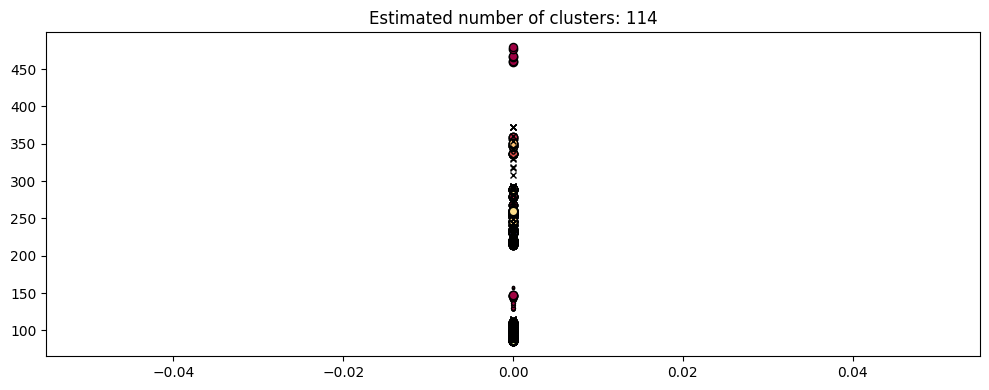

In [ ]:
plot(X, db.labels_, db.probabilities_)

### Assign labels to measurements for topic and find cluster centers

In [53]:
selected_topic = pd.DataFrame(train_topic_freqs.med_freq.loc[inspect_topic],
                              train_topic_freqs.band.loc[inspect_topic])\
    .reset_index()
selected_topic.columns = ['band', 'med_freq']
selected_topic['cluster_freq'] = labels

In [54]:
selected_topic.head()

,band,med_freq,cluster_freq
0,8,478.19,8
1,8,479.99,9
2,8,490.19,4
3,8,492.14,5
4,8,478.18,8


In [ ]:
px.histogram(selected_topic[selected_topic.cluster_freq == 1].med_freq, nbins=20)

In [ ]:
px.histogram(round(measurements[measurements.max_topic == 0].med_freq, 4))

### Option 1: Take mean of frequency median and difference by cluster to generate 'areas of interest'.
Using $mean(\text{median freq}) \pm \frac{mean(\text{frequency difference})}{2}$

### Option 2 CURRENT IMPLEMENTATION: Take min and max of frequency median by cluster to generate 'areas of interest'.

In [ ]:
topic_cluster = selected_topic.groupby('cluster_freq').agg(
    mean_freq=('med_freq', 'mean'),
    min_freq=('med_freq', 'min'),
    max_freq=('med_freq', 'max'),
    count_freq=('med_freq', 'count'),
    band_min=('band', 'min'),
    band_max=('band', 'max')
).sort_values('count_freq', ascending=False)
topic_cluster

,mean_freq,min_freq,max_freq,count_freq,band_min,band_max
cluster_freq,,,,,,
-1,207.759864,85.980,362.845,110,3,7
11,269.098000,268.805,269.140,15,6,6
40,220.216333,220.180,220.275,15,6,6
21,216.826667,216.235,217.170,15,6,6
56,230.438571,230.410,230.450,14,6,6
32,350.447857,347.320,352.075,14,7,7
20,109.810714,109.170,110.365,14,3,3
19,245.303846,244.035,247.460,13,6,6
47,219.376250,219.360,219.400,12,6,6


Drop cluster id = -1 as this is noise

In [ ]:
topic_cluster.head()

,Mean,Min,Max,Count
cluster_freq,,,,
23,234.415714,234.040,234.985,21
4,267.072000,264.015,270.405,20
1,141.059211,128.545,157.830,19
108,217.087368,217.060,217.100,19
30,218.465263,218.375,218.535,19


### Test topics in topic

In [ ]:
test_max_topic = test_doc_topic.idxmax(axis=1).to_frame()
test_max_topic.columns = ['max_topic']
test_max_topic.query(f'max_topic == {inspect_topic}')

,max_topic
2018.1.00302.S,48
2011.0.00217.S,48
2018.1.00312.S,48
2017.1.00474.S,48
2017.1.01116.S,48
2017.1.00114.S,48
2019.1.00402.S,48
2017.1.00793.S,48
2021.1.01417.S,48
2019.1.01768.S,48


In [ ]:
sorted(test_proj_meas.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values)

[[85.895,
  86.72,
  88.6,
  89.16,
  97.945,
  85.92,
  86.75,
  88.625,
  89.18,
  97.97,
  88.62,
  85.9,
  97.95,
  88.625,
  86.725],
 [85.93, 86.76, 88.495, 98.535, 100.3],
 [87.205, 89.09, 99.135, 101.09],
 [87.78,
  86.825,
  87.035,
  87.07,
  89.78,
  89.165,
  90.64,
  86.825,
  87.775,
  87.035,
  89.775,
  89.165],
 [90.66, 93.17],
 [90.82, 91.82, 92.49, 93.17, 90.66, 91.965, 92.49, 93.17],
 [91.175,
  93.195,
  103.215,
  104.915,
  89.2,
  93.175,
  97.985,
  110.205,
  89.195,
  97.995,
  110.22,
  97.995,
  110.215,
  93.185,
  89.185,
  91.175,
  93.195,
  103.215,
  104.915],
 [92.2, 93.17],
 [93.17],
 [93.175, 93.175],
 [93.175, 96.74, 93.17],
 [97.215, 98.825],
 [97.9, 98.94, 109.69, 110.11],
 [112.445, 113.14, 113.5, 115.27],
 [115.27],
 [130.5,
  131.55,
  144.47,
  145.4,
  291.225,
  293.21,
  303.405,
  305.105,
  130.5,
  131.55,
  144.47,
  145.4],
 [144.825, 154.215],
 [216.04, 217.03, 230.465, 231.24],
 [216.045,
  217.045,
  218.16,
  218.41,
  218.695,
 

### Check how many test measurement median frequencies fall within an area of interest generated by clustering

In [ ]:
# Add closest match frequency cluster!!!!!!!
test_project_index = 1
matches = 0
for freq in list(test_proj_meas.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values[test_project_index]):
    print(f'Testing frequency measurement {freq}')
    for cluster in topic_cluster.index.values:
        lower_bound = round(topic_cluster.iloc[cluster].Min, 3)
        upper_bound = round(topic_cluster.iloc[cluster].Max, 3)
        if ((freq >= lower_bound) and (freq <= upper_bound)):
            print(f'Test frequency measurement {freq} matches to cluster {cluster} range {lower_bound}-{upper_bound}')
            matches += 1
    num_measurements = len(list(test_proj_meas.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values[test_project_index]))
    print(f'Percent matches: {matches/num_measurements}')
    print('====================')

Testing frequency measurement 87.205
Test frequency measurement 87.205 matches to cluster 13 range 87.065-87.405
Percent matches: 0.25
Testing frequency measurement 89.09
Percent matches: 0.25
Testing frequency measurement 99.135
Test frequency measurement 99.135 matches to cluster 50 range 98.86-99.135
Percent matches: 0.5
Testing frequency measurement 101.09
Test frequency measurement 101.09 matches to cluster 72 range 101.05-101.65
Percent matches: 0.75


### Loop over topics and find accuracy measurements

In [ ]:
test_project_hits = 0               # Hits for all projects if at least one measurement is matched
test_project_meas_hit_rate = []     # List of hit rates by project
topic_cluster_widths = []           # List of cluster widths by topic to ensure generated clusters are not too wide (list of lists)
total_num_clusters = 0              # List of number of clusters for each topic
# Loop over topics
for tpc in params_frame.index:
    # DBSCAN with parameters from topic parameter data frame
    # BASIC COMPARISON PARAMETERIZATION: eps=0.5, min_samples=2
    # db = DBSCAN(eps=0.25, min_samples=2)\
    #     .fit(list(zip(train_topic_freqs.loc[tpc].med_freq)))
    # db = DBSCAN(eps=params_frame.loc[tpc].eps, min_samples=2)\
    # .fit(list(zip(train_topic_freqs.loc[tpc].med_freq)))
    db = HDBSCAN(max_cluster_size=20, min_cluster_size=5)\
    .fit(list(zip(train_topic_freqs.loc[tpc].med_freq)))
    
    # Get labels from DBSCAN
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_points = len(list(labels))
    n_noise = list(labels).count(-1)

    # Stat callouts
    print(f'HDBSCAN Results for topic {tpc}')
    #print(f'Estimated number of clusters: {n_clusters}')
    print(f'Number of projects in topic: {proj_max_topic.loc[train_texts.index].query(f"max_topic == {tpc}").shape[0]}')
    print(f'Total number of measurements: {n_points}')
    print(f'Estimated number of noise measurements: {n_noise}')
    print(f'Noise percentage: {round(list(labels).count(-1)/labels.shape[0], 3)}')
    print(f'Signal to noise ratio: {round(1-list(labels).count(-1)/labels.shape[0], 3)}')

    # Create data frame for measurements in this specific topic
    selected_topic = pd.DataFrame(train_topic_freqs.loc[tpc].med_freq,
                                  train_topic_freqs.loc[tpc].diff_freq)\
    .reset_index()
    selected_topic.columns = ['diff_freq', 'med_freq']
    selected_topic['cluster_label'] = labels

    # # Take mean of diff_freq and med_freq to generate areas of interest    
    # topic_cluster = selected_topic.groupby('cluster_freq').mean()
    # topic_cluster = topic_cluster.drop(-1, axis=0)  # Drop noise (label -1)
    # topic_cluster['lower_bound'] = topic_cluster.med_freq.min()
    # topic_cluster['upper_bound'] = topic_cluster.med_freq.max()
    # topic_cluster.sort_values('lower_bound', ascending=True)

    # Take mean of diff_freq and med_freq to generate areas of interest    
    topic_cluster = selected_topic.groupby('cluster_label').agg(
        mean_freq=('med_freq', 'mean'),
        min_freq=('med_freq', 'min'),
        max_freq=('med_freq', 'max')
    )

    # Check to see if there is noise from clustering
    # If so, drop noise cluster as we do not want to count hits there
    if (-1 in topic_cluster.index):
        topic_cluster = topic_cluster.drop(-1, axis=0) # Drop noise (label -1)
        topic_cluster.sort_values('min_freq', ascending=True)

    # Loop over generated clusters and print cluster stats
    # Initialize list of cluster widths
    cluster_widths = []
    for clst in topic_cluster.index:
        min_freq, max_freq = topic_cluster.loc[clst].min_freq, topic_cluster.loc[clst].max_freq
        cluster_widths.append(max_freq - min_freq)
        total_num_clusters += 1
    print(f'Topic {tpc} cluster stats:')
    print(np.round(pd.Series(cluster_widths).describe(), 4))

    # Get a list of test project codes
    tps = test_max_topic.query(f'max_topic == {tpc}')

    # Check to see if there are any test projects assigned to this topic
    # ADD IF, ELSE STATEMENT HERE, ATTACH ELSE TO FOLLOWING CODE

    #Begin test projects
    print('')
    print('Begin tests')

    # Loop over test projects
    for tp in tps.index:
        tp_hr = 0   # Hit rate for this specific project
        #print(f'Test project {tp}:')
        # Loop over measurements in test project
        for meas in test_proj_meas.loc[tp].med_freq:
            # Loop over clusters in topic
            for clust in topic_cluster.index.values:
                lower_bound = round(topic_cluster.loc[clust].min_freq, 3)
                upper_bound = round(topic_cluster.loc[clust].max_freq, 3)
                if ((meas >= lower_bound) and (meas <= upper_bound)):
                    tp_hr += 1
                    break
        test_project_meas_hit_rate.append(round(tp_hr/len(list(test_proj_meas.loc[tp].med_freq)), 3))
        #Print some stats
        # print(f'Number of measurements: {len(test_proj_meas.loc[tp].med_freq)}')
        # print(f'Hits: {tp_hr}')
        # print(f'Hit rate: {round(tp_hr/len(list(test_proj_meas.loc[tp].med_freq)), 3)}')
        # print('')

        # Increment test_project_hits if at least one measurement in the project matched
        if (tp_hr > 0):
            test_project_hits +=1
    print('=========================================\n')

print(f'Total number of clusters across topics: {total_num_clusters}')
print(f'Number of test projects with at least one measurement match: {test_project_hits}')
print(f'Ratio of test project hits to number of test projects: {test_project_hits/test_texts.shape[0]}')
print(f'Average hit rate per project: {sum(test_project_meas_hit_rate)/test_texts.shape[0]}')

HDBSCAN Results for topic 0
Number of projects in topic: 18
Total number of measurements: 189
Estimated number of noise measurements: 25
Noise percentage: 0.132
Signal to noise ratio: 0.868
Topic 0 cluster stats:
count    20.0000
mean      3.4700
std       3.4127
min       0.2050
25%       1.2262
50%       2.2525
75%       4.0538
max      12.3300
dtype: float64

Begin tests

HDBSCAN Results for topic 1
Number of projects in topic: 25
Total number of measurements: 270
Estimated number of noise measurements: 32
Noise percentage: 0.119
Signal to noise ratio: 0.881
Topic 1 cluster stats:
count    26.0000
mean      2.7383
std       3.7703
min       0.0700
25%       0.6587
50%       1.3550
75%       2.9487
max      14.6400
dtype: float64

Begin tests

HDBSCAN Results for topic 2
Number of projects in topic: 10
Total number of measurements: 45
Estimated number of noise measurements: 1
Noise percentage: 0.022
Signal to noise ratio: 0.978
Topic 2 cluster stats:
count     5.0000
mean     11.0240